In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Для тепловых карт
import seaborn as sns
# Простой датасет для классификации
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

plt.rcParams["figure.figsize"] = (20,6)
rng = np.random.default_rng(51)

## Функции активации и их дифференциал

In [2]:

def sigmoid(x):
  return 1 / (1 + np.exp(-x))


def dsigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))

sig_f = (sigmoid, dsigmoid)

def simpl_f(x):
  res = np.copy(x)
  res[res >= 0] = 1
  res[res < 0] = 0
  return res


def tanh(x):
  return np.tanh(x)


def dtanh(x):
  return 1 - np.square(tanh(x))

tanh_f = (tanh, dtanh)

# Средняя квадратичная ошибка
def mse(y_pred, y):
  # 1/n*sum((угаданное-Y)^2)
  err = np.mean(np.square(y_pred - y))
  return err


# y_pred - рассчитанное значение, y - ожидаемое
def dmse(y_pred, y):
  n = y.shape[0]
  return (2 / n) * (y_pred - y)

In [3]:
# Визуализация весов модели
def visualize_weights_with_biases(weights, biases, title='График'):
  """
  Делает тепловую карту для весов и смещения каждого нейрона каждого слоя

  -----
  :param weights: матрица размерности (k*i*j) где k- количество весов, i - нейроны текущего слоя, j - входы в нейрон
  :param biases: матрица размерности (k*i*1)
  :param title: Название для графиков (опционально)
  :return: none
  """
  for i, (weights, bias) in enumerate(zip(weights, biases)):
    # Транспонируем матрицу весов для замены строк и колонок
    weights_t = weights.T
   # добавляем смещение как дополнительную строку
    bias_row = bias.reshape(1, -1)
    combined_matrix = np.vstack([weights_t, bias_row])

    # Визуализируем тепловую карту
    plt.figure(figsize=(10, 6))
    sns.heatmap(combined_matrix, annot=True, cmap='coolwarm', cbar=False)
    plt.title(f'{title} для слоя {i + 1}')
    plt.xlabel('Нейроны')
    plt.ylabel('Вход и смещение(последнее)')
    plt.show()

In [4]:
def normalize(y_pred):
  """
  Нормализация результатов предсказания классификации от модели
  -----
  :param y_pred: предугаданные шансы для каждого класса
  :return: нормализованные вероятности, в сумме даёт 1
  """
  result = np.zeros_like(y_pred)
  for i, l in enumerate(y_pred):
    normalized  = (l - np.min(l)) / (np.max(l) - np.min(l))
    result[i] = normalized / np.sum(normalized)
  return result

In [5]:
def get_batches(data, batch_size):
  n = len(data)
  get_X = lambda z: z[0]
  get_y = lambda z: z[1]
  for i in range(0, n, batch_size):
    batch = data[i:i+batch_size]
    yield np.array([get_X(b) for b in batch]), np.array([get_y(b) for b in batch])

# Класс модели (возможно стоит выделить в отдельную библиотеку)

In [6]:
class MLP:
  """ Классический многослойный персептрон"""
  def __init__(self, architecture, lr=0.01, is_need_f_final=False, fn=(sigmoid, dsigmoid)):
    self.depth = len(architecture) - 1
    self.lr = lr
    # Требуется ли активационная функция на выходном слое
    self._is_need_func_final = is_need_f_final

    self.activation_fn = fn[0]
    self.activation_dfn = fn[1]

    self.error_fn = mse
    self.error_dfn = dmse

    #TODO: добавить сохранение весов и смещения, чтобы сохранять успешное обучение между запусками
    # Веса (k, i, j - k: номер слоя 0 = первый скрытый слой; i - конкретный нейрон; j - нейрон предыдущего слоя)
    self.W = self._init_weights(architecture)
    # Смещение (или порог активации)
    # (k, i, j - k: номер слоя 0 = первый скрытый слой; i - конкретный нейрон; j=1)
    self.b = self._init_biases(architecture)


# Прямое направление
    # Сумматор
    self.z = [None] * (self.depth+1)
    # Результат функции активации (кроме последнего слоя) (k: номер слоя: 0 - вход, 1 - первый скрытый слой; j количество нейронов на слое; l - количество данных на батч
    self.a = [None] * (self.depth+1)

    #Дельта правило (при инициализации заполняются 0)
    self.dW = [np.zeros_like(w) for w in self.W]
    self.db = [np.zeros_like(b) for b in self.b]

    # glorot uniform init
  def _init_weights(self, arch):
    net_in = arch[0]
    net_out = arch[-1]
    limit = np.sqrt(6. / (net_in + net_out))
    return [rng.uniform(-limit, limit + 1e-5, size=(arch[i+1], arch[i])) for i in range(self.depth)]

  def _init_biases(self, arch):
    return [rng.random((arch[i+1],1))*2-1 for i in range(self.depth)]

  def set_weights(self, new_W):
    self.W = new_W

  def set_biases(self, new_b):
    self.b = new_b

  def compute_loss(self, X, y):
    # X[l][in]
    y_pred = self.predict(X).reshape(y.shape)
    return self.error_fn(y_pred, y)

  # Расчет прямого прохождения для нескольких X
  def _feedforward(self, X):
    # W[0].shape[1] - количество входов = net_in
    # -1; X.shape[0] - количество значений в батче
    self.a[0] = X.T.reshape(self.W[0].shape[1], -1)
    # рассчитываем скрытые и выходной слои
    for k in range(self.depth):
      # перемножаются W [i (текущий слой), j (предыдущий)] * a[j (количество нейронов), l (количество в батче)]
      self.z[k+1] = np.matmul(self.W[k], self.a[k]) + self.b[k]
      # Выполняется только для скрытых слоев либо если передан _is_need_func_final
      #TODO : добавить отдельную функцию активации для выходного слоя
      if k != self.depth-1 or self._is_need_func_final:
        self.a[k+1] = self.activation_fn(self.z[k+1])
      else:
        self.a[-1] = self.z[-1]

# Расчет локального градиента при обратном распространении ошибок
  def _backprop(self, y, batch_size=32):
    # TODO сделать delta для выходящего слоя при _is_need_func_final и конкретной функции
    # a[j, l], y[l, in] -> y[in, l]
    delta = self.error_dfn(self.a[-1], y.T)
    if self._is_need_func_final:
      delta *= self.activation_dfn(self.z[-1])
    for k in range(self.depth-1, -1, -1):
      # Идем в обратном порядке. k - текущий слой, k+1 уже подсчитанный. j - количество нейронов в текущем слое. i - количество нейронов в k+1 слое
      if k != self.depth-1:

      # f(z[i][l]) * (dot (W[j][i], delta[i][l]) получаем [j][l], так как для W[k].shape(i) = z[k].shape(j)
        delta = self.activation_dfn(self.z[k+1]) * np.matmul(self.W[k+1].T, delta)
      # dot(delta[j][l], a[l][j]) должны получить dW[i, j]
      self.dW[k] = np.matmul(delta, self.a[k].T)
      # delta[j][1] sum l
      self.db[k] = np.sum(delta, axis=1, keepdims=True)

  # simple sgd
  def _update_params(self, lr=1e-2):
    for k in range(self.depth):
      self.W[k] -= lr*self.dW[k]
      self.b[k] -= lr*self.db[k]

  def train(self, X, y, lr=None, epochs=50, batch_size=32):
    """
    Обучение модели.

    -------
    :param X: Размерности l * in, где l количество входящих данных, in - количество входов
    :param y: Размерности l * out.
    :param lr:  learning rate, по умолчанию берет значение из MLP.lr
    :param epochs: Количество эпох, по умолчанию 50.
    :param batch_size: Количество данных в одном батче. По умолчанию 32.
    :return: Возвращает вектора loss и dW(mean каждого слоя) по эпохам
    """
    lr = lr if lr is not None else self.lr

    epoch_losses = np.array([])
    epoch_grad_w = np.zeros((len(self.dW), epochs))
    dataset = list(zip(X, y))
    for i in range(epochs):
      rng.shuffle(dataset)
      for (X_batch, y_batch) in get_batches(dataset, batch_size):
        self._feedforward(X_batch)
        self._backprop(y_batch)
        self._update_params(lr=lr)

      epoch_losses = np.append(epoch_losses, self.compute_loss(X, y))
      for k in range(len(self.dW)):
        epoch_grad_w[k][i] = np.mean(self.dW[k])
    return epoch_losses, epoch_grad_w

  def predict_proba(self, X, is_classification=False):
    """
    Предсказать значение на уже обученной модели.

    ------
    :param X:На вход X размерности l * out, где l - количество полученных данных, out - количество выходящих нейронов.
    :param is_classification: является ли это предсказание класса? Если да, то возвращает вероятность к конкретному классу
    :return: Возвращает a размерности l * out
    """
    a = X.T.reshape(self.W[0].shape[1], -1)
    # compute hidden and output layers
    for i in range(self.depth):
      a = np.matmul(self.W[i], a) + self.b[i]
      if i != self.depth-1 or self._is_need_func_final:
        a = self.activation_fn(a)
    a = a.T
    if is_classification:
      a = normalize(a)
    return a

  def predict(self, X, is_classification=False):
    """
    Предсказать значение на уже обученной модели.

    ------
    :param X:На вход X размерности l * out, где l - количество полученных данных, out - количество выходящих нейронов.
    :param is_classification: является ли это предсказание класса? Если да, то возвращает вероятность к конкретному классу
    :return: Возвращает a размерности l * out (если is_classification=True то out=1)
    """
    res = self.predict_proba(X, is_classification)
    if is_classification:
      return np.array([np.argmax(l) for l in res])
    else:
      return res



# Используем модель

In [7]:
data = load_iris()

In [8]:
# 1. Загрузка данных
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=['target'])

In [9]:
# 2. Проверка данных
print(X.head())
print(y.value_counts())

# 3. Проверка на пропуски
# print(X.isnull().sum())

# 4. Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Преобразование меток y в формат one-hot
encoder = OneHotEncoder(sparse_output=False)
y_one_hot = encoder.fit_transform(y)

# 6. Разделение на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_one_hot, test_size=0.3, random_state=42)

y_train_class = encoder.inverse_transform(y_train)
y_test_class = encoder.inverse_transform(y_test)


   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2
target
0         50
1         50
2         50
dtype: int64


In [10]:
X_scaled

array([[-9.00681170e-01,  1.01900435e+00, -1.34022653e+00,
        -1.31544430e+00],
       [-1.14301691e+00, -1.31979479e-01, -1.34022653e+00,
        -1.31544430e+00],
       [-1.38535265e+00,  3.28414053e-01, -1.39706395e+00,
        -1.31544430e+00],
       [-1.50652052e+00,  9.82172869e-02, -1.28338910e+00,
        -1.31544430e+00],
       [-1.02184904e+00,  1.24920112e+00, -1.34022653e+00,
        -1.31544430e+00],
       [-5.37177559e-01,  1.93979142e+00, -1.16971425e+00,
        -1.05217993e+00],
       [-1.50652052e+00,  7.88807586e-01, -1.34022653e+00,
        -1.18381211e+00],
       [-1.02184904e+00,  7.88807586e-01, -1.28338910e+00,
        -1.31544430e+00],
       [-1.74885626e+00, -3.62176246e-01, -1.34022653e+00,
        -1.31544430e+00],
       [-1.14301691e+00,  9.82172869e-02, -1.28338910e+00,
        -1.44707648e+00],
       [-5.37177559e-01,  1.47939788e+00, -1.28338910e+00,
        -1.31544430e+00],
       [-1.26418478e+00,  7.88807586e-01, -1.22655167e+00,
      

In [11]:
net_arch_iris = (4, 25, 15, 3)
mlp_iris = MLP(net_arch_iris, fn=tanh_f, is_need_f_final=True)

In [12]:
epochs = 150
loss_epoches, dW_epoches = mlp_iris.train(X_train, y_train, epochs=epochs, lr=0.001)

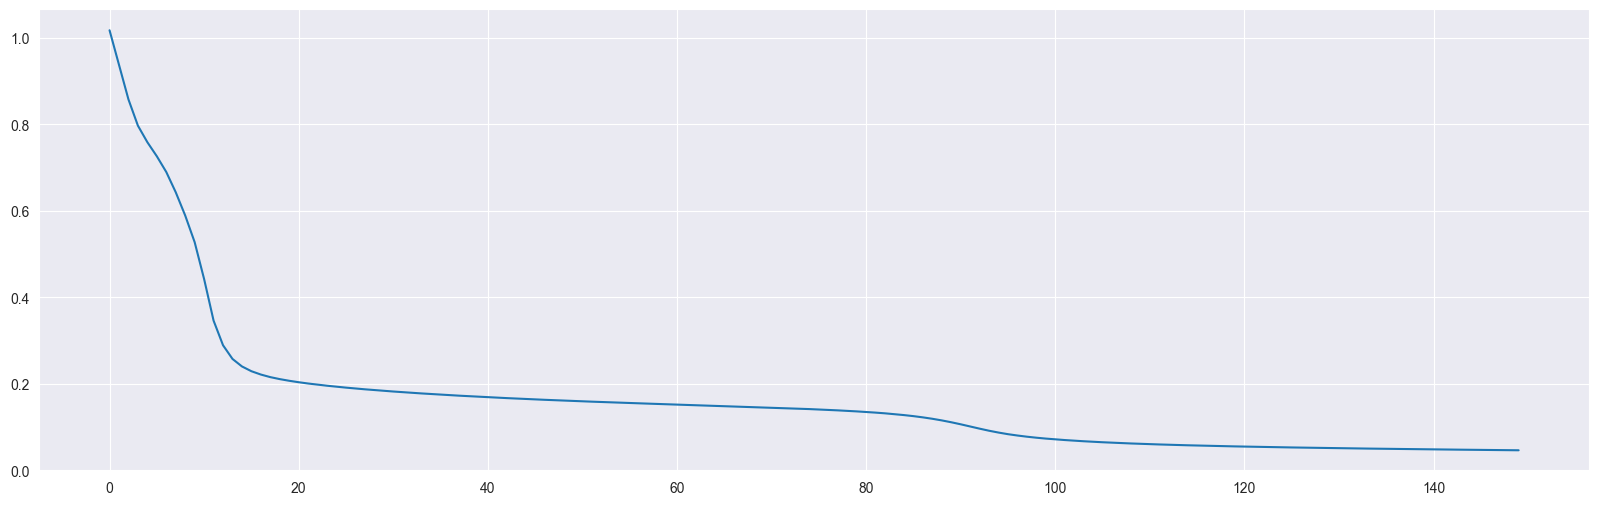

In [13]:
plt.plot(loss_epoches)

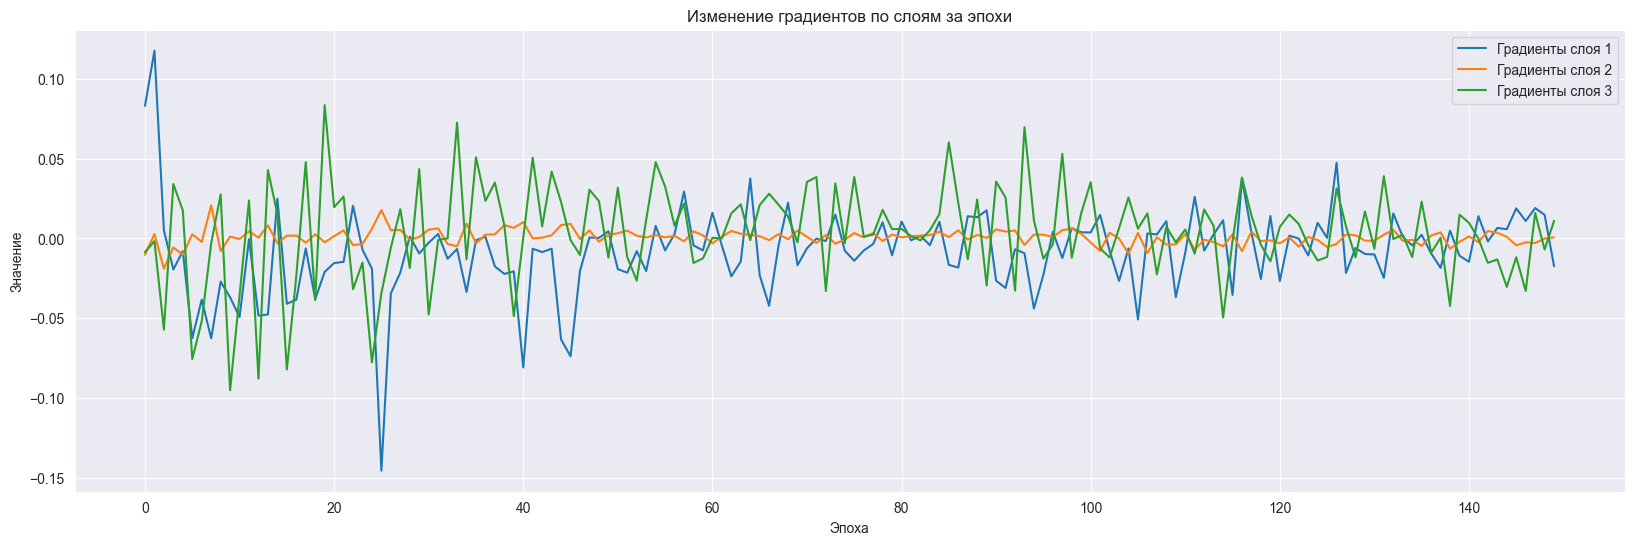

In [14]:
# Визуализация градиентов на одном графике
for layer in range(dW_epoches.shape[0]):
    plt.plot(range(epochs), dW_epoches[layer, :], label=f'Градиенты слоя {layer + 1}')

plt.title('Изменение градиентов по слоям за эпохи')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.legend(loc='upper right')  # Легенда для обозначения линий
plt.grid(True)  # Сетка для лучшего визуального восприятия
plt.show()

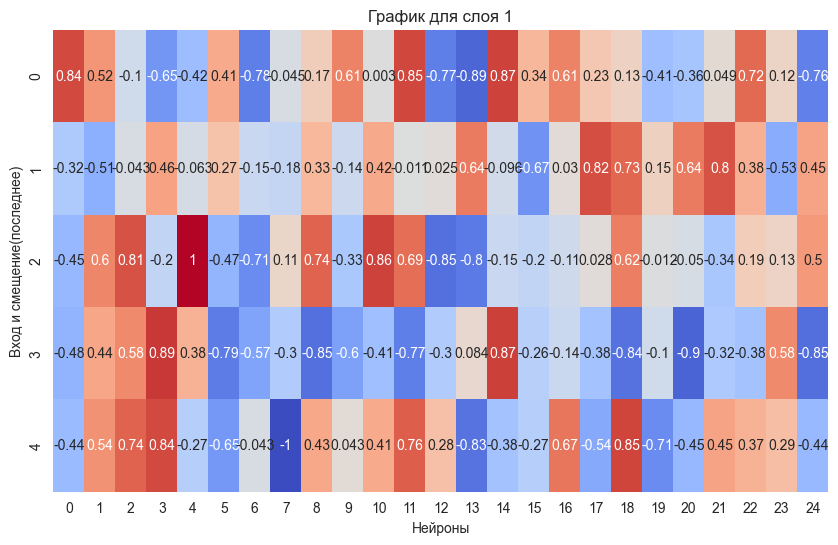

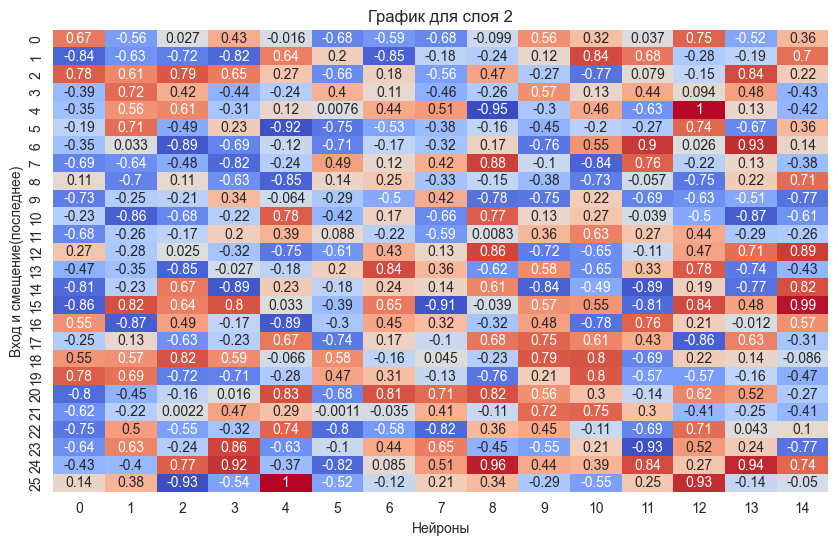

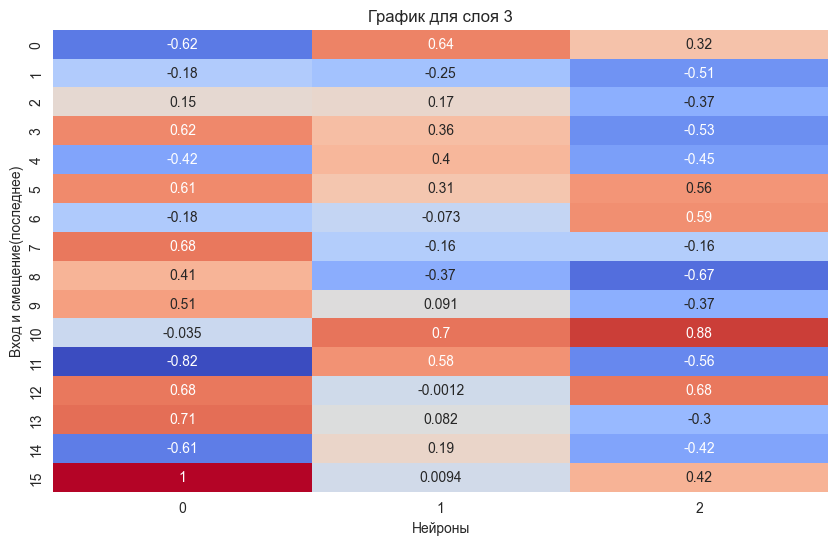

In [15]:
visualize_weights_with_biases(mlp_iris.W, mlp_iris.b)

In [16]:
res = mlp_iris.predict(X_test).T
print('Входящие данные\n',X_test, y_test)
print('Результат:\n',res)
print('Loss\n', mlp_iris.compute_loss(X_train, y_train))

Входящие данные
 [[ 3.10997534e-01 -5.92373012e-01  5.35408562e-01  8.77547895e-04]
 [-1.73673948e-01  1.70959465e+00 -1.16971425e+00 -1.18381211e+00]
 [ 2.24968346e+00 -1.05276654e+00  1.78583195e+00  1.44883158e+00]
 [ 1.89829664e-01 -3.62176246e-01  4.21733708e-01  3.95774101e-01]
 [ 1.15917263e+00 -5.92373012e-01  5.92245988e-01  2.64141916e-01]
 [-5.37177559e-01  7.88807586e-01 -1.28338910e+00 -1.05217993e+00]
 [-2.94841818e-01 -3.62176246e-01 -8.98031345e-02  1.32509732e-01]
 [ 1.28034050e+00  9.82172869e-02  7.62758269e-01  1.44883158e+00]
 [ 4.32165405e-01 -1.97355361e+00  4.21733708e-01  3.95774101e-01]
 [-5.25060772e-02 -8.22569778e-01  8.07091462e-02  8.77547895e-04]
 [ 7.95669016e-01  3.28414053e-01  7.62758269e-01  1.05393502e+00]
 [-1.26418478e+00 -1.31979479e-01 -1.34022653e+00 -1.44707648e+00]
 [-4.16009689e-01  1.01900435e+00 -1.39706395e+00 -1.31544430e+00]
 [-1.14301691e+00  9.82172869e-02 -1.28338910e+00 -1.44707648e+00]
 [-9.00681170e-01  1.70959465e+00 -1.28338910

In [18]:
res_proba = mlp_iris.predict_proba(X_test, True)

In [19]:
res_proba

array([[0.        , 0.66750215, 0.33249785],
       [0.78091643, 0.21908357, 0.        ],
       [0.        , 0.16293267, 0.83706733],
       [0.        , 0.53521127, 0.46478873],
       [0.        , 0.64532668, 0.35467332],
       [0.79417382, 0.20582618, 0.        ],
       [0.12584258, 0.87415742, 0.        ],
       [0.28489849, 0.        , 0.71510151],
       [0.        , 0.62982129, 0.37017871],
       [0.14439804, 0.85560196, 0.        ],
       [0.        , 0.14618446, 0.85381554],
       [0.75704361, 0.24295639, 0.        ],
       [0.74474091, 0.25525909, 0.        ],
       [0.78783242, 0.21216758, 0.        ],
       [0.84403932, 0.        , 0.15596068],
       [0.        , 0.67849696, 0.32150304],
       [0.0373305 , 0.        , 0.9626695 ],
       [0.14301779, 0.85698221, 0.        ],
       [0.03346769, 0.96653231, 0.        ],
       [0.02837712, 0.        , 0.97162288],
       [0.99207709, 0.00792291, 0.        ],
       [0.        , 0.34067287, 0.65932713],
       [0.

In [20]:
res_class = mlp_iris.predict(X_test, True)

In [21]:
res_class

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0], dtype=int64)

# Расчет метрик

In [22]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [23]:
class Metrics:

  def __init__(self, y_pred, y):
    self.confusion_matrix = self._init_confusion_matrix(y_pred, y)
    self.accuracy = np.trace(self.confusion_matrix) \
                    / np.sum(self.confusion_matrix)
    confusion_matrix = self.confusion_matrix
    # Инициализируем списки для precision, recall и F1 для каждого класса
    precision = []
    recall = []
    f1_score = []

    # Рассчитываем метрики для каждого класса
    for i in range(len(self.confusion_matrix)):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP
        FN = np.sum(confusion_matrix[i, :]) - TP
        TN = np.sum(confusion_matrix) - (TP + FP + FN)

        # Precision, Recall, F1 для класса i
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0
        rec = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1_score.append(f1)

        print(f"Class {i}: Precision = {prec:.4f}, Recall = {rec:.4f}, F1-Score = {f1:.4f}")
    self.precision = precision
    self.recall = recall
    self.f1_score = f1_score

  def _init_confusion_matrix(self, y_pred, y):
    n = max(np.max(y_pred), np.max(y)) + 1
    matrix = np.zeros((n, n))
    for i in range(len(y_pred)):
      pred_class = y_pred[i]
      class_label = y[i]
      matrix[pred_class, class_label] += 1
    return matrix


In [24]:
res_proba = mlp_iris.predict(X_test, True)
# evaluate_model(res_proba, encoder.inverse_transform(y_train))

In [25]:
metrics = Metrics(res_proba, encoder.inverse_transform(y_test))
metrics.confusion_matrix

Class 0: Precision = 1.0000, Recall = 1.0000, F1-Score = 1.0000
Class 1: Precision = 1.0000, Recall = 1.0000, F1-Score = 1.0000
Class 2: Precision = 1.0000, Recall = 1.0000, F1-Score = 1.0000


array([[19.,  0.,  0.],
       [ 0., 13.,  0.],
       [ 0.,  0., 13.]])

In [26]:
metrics.accuracy

1.0

## ROC-кривая

In [27]:
def roc_curve_manual(y_true, y_pred_proba, class_label):
  """

  :param y_true: изначальные y размерности (l,)
  :param y_pred_proba: результат расчета вероятностей для классов размерности (l, k)
  :param class_label: класс, для которого рассчитываем roc
  :return:
  """
  y_true = y_true.reshape(-1)
  y_pred_proba_class = y_pred_proba[:, class_label].copy() # Берем вероятности только для class_label
  thresholds = np.sort(np.unique(y_pred_proba_class))[::-1]  # пороги сортируются по убыванию
  tpr_list = []
  fpr_list = []

  for threshold in thresholds:
      y_pred = (y_pred_proba_class >= threshold).astype(int)

      tp = np.sum((y_pred == 1) & (y_true == class_label))
      fn = np.sum((y_pred == 0) & (y_true == class_label))
      fp = np.sum((y_pred == 1) & (y_true != class_label))
      tn = np.sum((y_pred == 0) & (y_true != class_label))

      tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
      fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

      tpr_list.append(tpr)
      fpr_list.append(fpr)

  return fpr_list, tpr_list

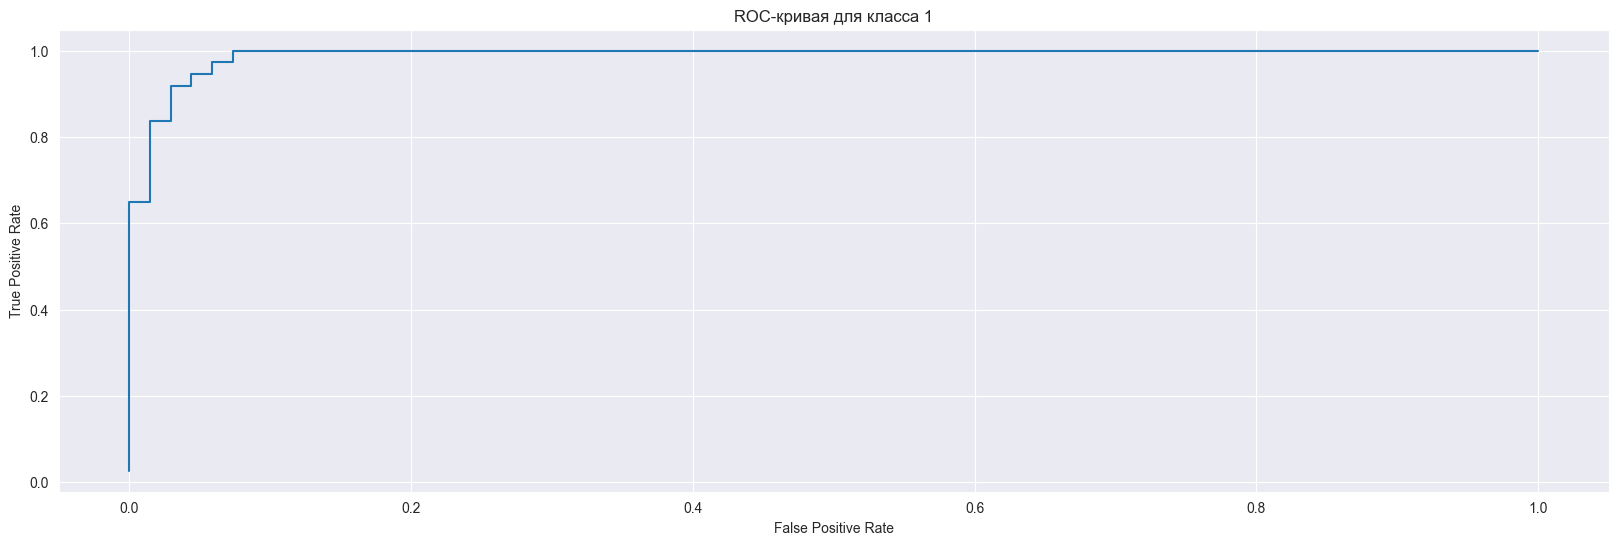

In [28]:
# ROC кривая для класса 1
y_pred_proba = mlp_iris.predict_proba(X_train, True)
fpr, tpr = roc_curve_manual(y_train_class, y_pred_proba, 2)

# Построение ROC-кривой
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, label="Class 1 ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая для класса 1")
plt.show()

## Просто какие-то тесты

In [29]:
y_pred_proba[:,1:2].shape

(105, 1)

In [30]:
res_proba2 = mlp_iris.predict(X_train, True)

In [31]:
metrics2 = Metrics(res_proba2, encoder.inverse_transform(y_train))
metrics2.confusion_matrix

Class 0: Precision = 1.0000, Recall = 1.0000, F1-Score = 1.0000
Class 1: Precision = 0.8919, Recall = 0.9429, F1-Score = 0.9167
Class 2: Precision = 0.9459, Recall = 0.8974, F1-Score = 0.9211


array([[31.,  0.,  0.],
       [ 0., 33.,  2.],
       [ 0.,  4., 35.]])

In [32]:
metrics2.accuracy

0.9428571428571428